# Model Training by keras

## Imports

In [1]:
import os
import time
from utils import data_importer
from utils import model as md
from utils import unet, fcrn, metrics
from IPython.display import clear_output

import matplotlib.pyplot as plt
import numpy as np

### TensorFlow importing and settings:

In [2]:
import tensorflow as tf

tf.config.optimizer.set_jit(True)
from tensorflow.keras import backend as K

###########  Logging device placement  ######
# tf.debugging.set_log_device_placement(True)

###########  Manual device placement & Limiting GPU memory growth #######
GPU_ID = 0
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
physical_gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[GPU_ID], True) #Sllocate memory as-needed
tf.config.experimental.set_visible_devices(physical_gpus[GPU_ID], 'GPU')
logical_gpus = tf.config.experimental.list_logical_devices('GPU')
print(len(physical_gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")

# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# K.set_session(tf.Session(config=config))

2 Physical GPUs, 1 Logical GPU


## Imporing Dataset

### Datasets settings

In [3]:
COMMON_SETTING = {
    'table_address' : "./utils/labels.csv",
    'batch_size' : 1, 
    'output_shape' : (480, 640),
    'data_type' : 'float32',
    'feature_types' : ['image','segmentation'  ],# 
    'label_types' : ['depth'],# ['depth'], #, 'semantic_depth'
    'class_ids' : 'all'#[55,]#data_importer.COMMON_LABEL_IDS.copy()#
}

############################ SYNTHIA_SF_SETTINGS ########################################
address = 'C:/Users/KINEMATIX/Amin/Datasets/SYNTHIA-SF'#'D:/Library/Datasets/SYNTHIA-SF'#
dsg = data_importer.SynthiaSf
usage_range_train = (0, 1)
usage_range_validation = (0.75, 1)
usage_range_test = (0.75, 1)

############################ VIPER_SETTINGS ############################
# address = 'D:/Library/Datasets/(GTA-V)Playing for Benchmarks'
# dsg = data_importer.VIPER
# usage_range_train = (0, 1)
# usage_range_validation = (0, 1)
# usage_range_test = (0, 1)

############################ MAPILLARY_SETTINGS ############################
# address = 'D:/Library/Datasets/mapillary-vistas-dataset_public_v1.1'
# dsg = data_importer.MAPILLARY
# usage_range_train = (0, 1)
# usage_range_validation = (0, 1)
# usage_range_test = (0, 1)

############################ CITYSCAPES_SETTINGS ############################
# address = 'D:/Library/Datasets/cityscapes'
# dsg = data_importer.CITYSCAPES
# usage_range_train = (0, 1)
# usage_range_validation = (0, 1)
# usage_range_test = (0, 1)

### Creating dataset generator

In [4]:
dsg_train = dsg(**COMMON_SETTING,
                dataset_dir=address,
                usage='train',
                usage_range=usage_range_train)

dsg_validation = dsg(**COMMON_SETTING,
                    dataset_dir=address,
                    usage='validation',
                    usage_range=usage_range_validation)
# dsg_test = dsg(**COMMON_SETTING,
#                     dataset_dir=address,
#                     usage='test',
#                     usage_range=usage_range_test)

C:\Users\KINEMATIX\.conda\envs\tf\lib\site-packages\pandas\core\ops\__init__.py:1069: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x, y, op)


### Preview of dataset

In [5]:
preview = iter(dsg_train)

In [6]:
feature_list, label_list=next(preview)

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from utils import visualizer as vis

options=['Simple plot', 'RGB point cloud', 'Segmented point cloud']

def f(num_slider, num_play, layer_slider, layer_play):

    class_name = dsg_train.label_table.loc[dsg_train.class_ids[layer_slider-1]][0]
    vis.draw_samples(feature_list, label_list, num_slider-1,
                     feature_types=COMMON_SETTING['feature_types'], 
                     label_types=COMMON_SETTING['label_types'], 
                     class_name = class_name,
                     class_index=layer_slider-1)
    
def f2(x):
    vis.draw_point_cloud(label_list[0][x-1], feature_list[0][x-1])
    
def view_type_selector(y):
    if y == options[0]:
        num_slider = widgets.IntSlider(description="Sample Num", min=1, max=dsg_train.batch_size, continuous_update=False)
        num_play = widgets.Play(interval=1000,  min=1,    max=dsg_train.batch_size,    step=1,    description="Sample Num",    disabled=False)
        widgets.jslink((num_slider, 'value'), (num_play, 'value'))
        
        layer_slider = widgets.IntSlider(description="Sample layer", min=1, max=len(dsg_train.class_ids), continuous_update=False)
        layer_play = widgets.Play(interval=1000,  min=1,    max=len(dsg_train.class_ids),    step=1,    description="Sample layer",    disabled=False)
        widgets.jslink((layer_slider, 'value'), (layer_play, 'value'))
        
        interact(f, 
                 num_slider=num_slider,
                 num_play=num_play,
                 layer_slider=layer_slider,
                 layer_play=layer_play)
        
    if y == options[1]:
        interact_manual(f2,
                        x=widgets.IntSlider(description="Sample Num", min=1, max=dsg_train.batch_size, continuous_update=False))
    else:
        print(y)
        
x=interact_manual(view_type_selector, y=widgets.Dropdown(description="View type:", options=options))

interactive(children=(Dropdown(description='View type:', options=('Simple plot', 'RGB point cloud', 'Segmented…

## Building the Model

In [8]:
num_of_classes = dsg_train.class_ids.size

tf.keras.backend.set_floatx('float32')
# inputs = tf.keras.Input(shape=(480,640,3))
# model = md.deep_lab_v3(inputs=inputs, output_stride = 32)
# model = unet.model(img_shape=(480,640,3),num_of_class=19)

model = fcrn.model_m19(rgb_shape=(480,640,3), seg_shape=(480, 640, num_of_classes))#rgb_shape=(480,640,3), seg_shape=(480, 640, num_of_classes)

model.summary()

Model: "FCRN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 480, 640, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(4,)]               0           input_1[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_strided_slice (Tens [()]                 0           tf_op_layer_Shape[0][0]          
__________________________________________________________________________________________________
tf_op_layer_sobel_filters/multi [(4,)]               0           tf_op_layer_strided_slice[0][0]  
_______________________________________________________________________________________________

In [9]:
# model = tf.keras.utils.multi_gpu_model(model, gpus=2)

## for segmetation training
# model.compile(optimizer='adam', loss=metrics.bce_dice_loss_nb, metrics=[metrics.dice_loss_nb])

## for segmetation evaluating: IUO class 
# class_list = []
# for i, label_id in enumerate(data_importer.COMMON_LABEL_IDS):
#     class_list.append(dsg_validation.label_table.name[label_id].replace(' ', '_').replace('(', '').replace(')', ''))
    
# metric_list = metrics.class_IOU_list(class_list)
# model.compile(optimizer='adam', loss=metrics.mean_IOU_loss, metrics=metric_list) 

smooth = 1e-6
metric_list={'Prediction':[metrics.MAPE(), metrics.MSPE(), metrics.RMSE(), metrics.RMSELog(smooth=smooth),
                                                                     metrics.Log10(smooth=smooth), metrics.DeltaThreshold(i=1), 
                                                                     metrics.DeltaThreshold(i=2), metrics.DeltaThreshold(i=3), 
                                                                     metrics.SILog(smooth=smooth)]}
# metric_list=[[metrics.MAPE(), metrics.MSPE(), metrics.RMSE(), metrics.RMSELog(smooth=smooth),
#                                                                      metrics.Log10(smooth=smooth), metrics.DeltaThreshold(i=1), 
#                                                                      metrics.DeltaThreshold(i=2), metrics.DeltaThreshold(i=3), 
#                                                                      metrics.SILog(smooth=smooth)]]

## for depth trainig
model.compile(optimizer="adam", loss=metrics.MAPE(), metrics=metric_list)

ValueError: Unknown entries in metrics dictionary: ['Prediction']. Only expected following keys: ['predict']

## Training

In [ ]:
import pandas as pd
class visual_logger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, validation_dataset, index=0):
        super().__init__()
        self.log_dir = log_dir
        if 'visual_log.pkl' in os.listdir(log_dir):
            self.result_dataframe = pd.read_pickle(log_dir + "/visual_log.pkl")
        else:
            self.result_dataframe = pd.DataFrame()
            
        if 'metric_log.pkl' in os.listdir(log_dir):
            self.metric_dataframe = pd.read_pickle(log_dir + "/metric_log.pkl")
        else:
            self.metric_dataframe = pd.DataFrame()
        
        validation_dataset.index = index
        preview = iter(validation_dataset)
        self.feature_list, self.label_list=next(preview)
        
        self.result_dataframe['feature_list'] = [self.feature_list]
        self.result_dataframe['label_list'] = [self.label_list]
        
    def on_epoch_end(self, epoch, logs):
        predict=self.model.predict(self.feature_list, steps=1)
        self.result_dataframe['predict ' + str(epoch)] = [predict]
        self.result_dataframe.to_pickle(self.log_dir + 'visual_log.pkl')
        
        if self.metric_dataframe.columns.size == 0:
            self.metric_dataframe= pd.DataFrame(columns=['epoch','time',] + list(logs.keys()))
        self.metric_dataframe.loc[epoch] = np.array([epoch, time.time(),] + list(logs.values()), dtype=np.float64)
        self.metric_dataframe.to_pickle(self.log_dir + 'metric_log.pkl')

In [ ]:
address = './log/depth/M1_all_MAPE/'

In [12]:
model.load_weights(address +'my_keras_model.h5')

In [12]:
try:
    os.makedirs(address + 'plugins/profile/')
except FileExistsError:
    pass

train_step = 2#np.int((dsg_train.end_index - dsg_train.start_index)/COMMON_SETTING['batch_size'])
validation_steps = 2#np.int((dsg_validation.end_index - dsg_validation.start_index)/COMMON_SETTING['batch_size'])
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(address + "my_keras_model.h5"),
    tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir=address, update_freq='batch'),
    visual_logger(address, dsg_validation, index=0)
]
history = model.fit_generator(dsg_train, steps_per_epoch=train_step, epochs=50, callbacks=callbacks, 
                    validation_data=dsg_validation, validation_steps=validation_steps, initial_epoch=0)

Epoch 1/50
2/2 [==============================] - 17s 8s/step - loss: 89.8179 - MAPE: 89.8179 - MSPE: 15717.2988 - RMSE: 381.4383 - RMSELog: nan - Log10: nan - delta_threshold_1: 0.3523 - delta_threshold_2: 0.3789 - delta_threshold_3: 0.4112 - SILog: nan - val_loss: 704.2017 - val_MAPE: 704.2017 - val_MSPE: 56860.0391 - val_RMSE: 423.1604 - val_RMSELog: nan - val_Log10: nan - val_delta_threshold_1: 0.9996 - val_delta_threshold_2: 0.9996 - val_delta_threshold_3: 0.9996 - val_SILog: nan
Epoch 2/50
2/2 [==============================] - 6s 3s/step - loss: 76.4360 - MAPE: 76.4360 - MSPE: 23264.7246 - RMSE: 470.7669 - RMSELog: nan - Log10: nan - delta_threshold_1: 0.2240 - delta_threshold_2: 0.2914 - delta_threshold_3: 0.3414 - SILog: nan - val_loss: 20879.4873 - val_MAPE: 20879.4883 - val_MSPE: 52911352.0000 - val_RMSE: 3136.8511 - val_RMSELog: nan - val_Log10: nan - val_delta_threshold_1: 1.0000 - val_delta_threshold_2: 1.0000 - val_delta_threshold_3: 1.0000 - val_SILog: nan
Epoch 3/50
2/

KeyboardInterrupt: 

## Histogram of accuracy

In [13]:
import pandas as pd
import plotly.express as px

In [14]:
max_range = 50
distance_step = 5
max_error = 2
thresholds_step = 0.02

thresholds = ["{:4.2f}-{:4.2f}".format(i*thresholds_step,(i+1)*thresholds_step) for i in range(int(max_error/thresholds_step))]

In [15]:
predict = model.predict(feature_list)
p = []
r = []
t = []
for i in range(int(max_range/distance_step)):
    d_min = i*distance_step
    d_max = (1+i)*distance_step
    a = (label_list[0][0]- predict[0])*(d_min<label_list[0][0] )*(label_list[0][0]<d_max)
    bins = np.arange(0.001, max_error + 0.001+thresholds_step, thresholds_step)
    p.append (np.histogram(a, bins)[0] / np.histogram(a, bins)[0].sum())
    r.append (["{}-{}".format(d_min, d_max) for i in range(len(thresholds))])
    t.append (thresholds)

In [16]:
p = np.array(p) * 0

In [17]:
dsg_validation.index = dsg_validation.start_index
preview = iter(dsg_validation)

start_time = time.perf_counter()
for j in range(dsg_validation.size):
    feature_list, label_list=next(preview)
    predict = model.predict(feature_list)
    
    for i in range(int(max_range/distance_step)):
        d_min = i*distance_step
        d_max = (1+i)*distance_step
        a = (label_list[0][0]- predict[0])*(d_min<label_list[0][0] )*(label_list[0][0]<d_max)
        bins = np.arange(0.001, max_error + 0.001+thresholds_step, thresholds_step)
        p[i] = np.histogram(a, bins)[0]

    
    percent = j/dsg_validation.size
    elapsed_time = time.perf_counter() - start_time
    total_time = elapsed_time /(j+1) * dsg_validation.size
    ETA = total_time - elapsed_time
    
    print("Progress: {:4.2f}%".format( percent*100))
    print('ETA: {}:{}'.format(int(ETA//60), int(ETA%60)))
    print("Runtime: {:4.2f}".format(elapsed_time/(j+1)))
    clear_output(wait=True)

Progress: 99.91%
ETA: 0:0
Runtime: 0.61


In [18]:
pp = [p[i]/p[i].sum() for i in range(len(p))]

In [19]:
r = np.reshape(r,-1)
t = np.reshape(t,-1)
pp = np.concatenate(pp)
df = pd.DataFrame({"range":r, "thresholds":t, "Percentage":pp})

In [20]:
from mpl_toolkits.mplot3d import Axes3D
Axes3D.plot_wireframe

<function mpl_toolkits.mplot3d.axes3d.Axes3D.plot_wireframe(self, X, Y, Z, *args, **kwargs)>

In [21]:
model_name = 'M1'
log_dir = './log/depth/' + model_name + '_all_MAPE/'

In [22]:
fig = px.scatter_3d(df, y="range", x="thresholds", z="Percentage", color="Percentage",
                   color_continuous_scale=px.colors.sequential.Rainbow)
fig.layout.title = 'Histogram of accuracy in various distance intervals - ' + model_name +' Network'
fig.write_html(log_dir + fig.layout.title.text + ".html")
df.to_pickle(log_dir + 'accuracy_histogram.pkl')
fig.show()

### SOL Evaluation

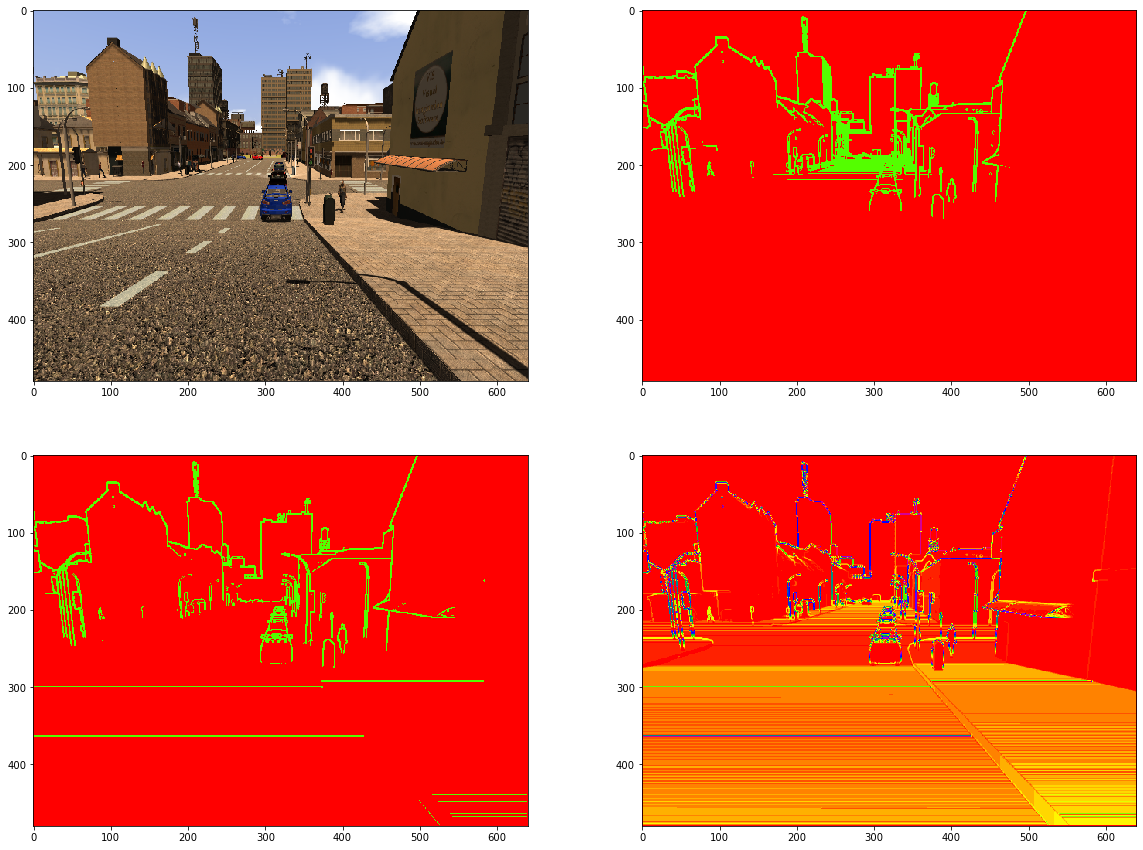

In [211]:
import skimage
import skimage.filters as f
plt.figure(figsize=(20, 15))
plt.subplot(2,2,1)
plt.imshow(feature_list[0][0])
plt.subplot(2,2,2)
plt.imshow(f.sobel(label_list[0][0][:, :, 0])>2)
plt.subplot(2,2,3)
m = SOL()
plt.imshow(f.sobel(m.log_loop(label_list[0][0][:, :, 0]))>0.02)
plt.subplot(2,2,4)
plt.imshow(f.sobel(m.log_loop(label_list[0][0][:, :, 0])))
plt.set_cmap("prism")

In [34]:
class SOL(tf.keras.losses.Loss):
    """Differences of Sobel of Multiple logs
    """
    def __init__(self, base=1.1, loop_num=4, smooth=0.01, reduction=tf.keras.losses.Reduction.AUTO):
        super().__init__(reduction=reduction, name='SOL')
        self.loop_num = loop_num
        self.base = base
        self.smooth = smooth

    def log_loop(self, a):
        result = a
        for _ in range(self.loop_num):
            result = tf.math.log(result+self.smooth)/tf.math.log(self.base)
        return result

    def call(self, y_true, y_pred):
        "Computes and returns the metric value tensor."
        y_true_log_sobel = tf.image.sobel_edges(self.log_loop(y_true))
        y_pred_log_sobel = tf.image.sobel_edges((self.log_loop(y_pred)))
        difference = abs(y_true_log_sobel - y_pred_log_sobel)
        return tf.math.log(tf.reduce_sum(difference))

In [35]:
class SOL(tf.keras.losses.Loss):
    """Differences of Sobel of Multiple logs
    """
    def __init__(self, base=1.1, loop_num=4, smooth=0.01, reduction=tf.keras.losses.Reduction.AUTO):
        super().__init__(reduction=reduction, name='SOL')
        self.loop_num = loop_num
        self.base = base
        self.smooth = smooth

    def log_loop(self, a):
        result = a
        for _ in range(self.loop_num):
            result = tf.math.log(result+self.smooth)/tf.math.log(self.base)
        return result

    def call(self, y_true, y_pred):
        "Computes and returns the metric value tensor."
        y_true_log_sobel =  tf.image.sobel_edges(self.log_loop(y_true))>0.02
        y_pred_log_sobel = tf.image.sobel_edges((self.log_loop(y_pred)))>0.02
        difference = abs(y_true_log_sobel - y_pred_log_sobel)
        return tf.math.log(tf.reduce_sum(difference))

In [33]:
dsg_validation.index = dsg_validation.start_index
preview = iter(dsg_validation)
m = SOL(loop_num=4, base=1.5, smooth=1.5)
sol=0
start_time = time.perf_counter()
for i in range(dsg_validation.size):
    feature_list, label_list=next(preview)
    predict = model.predict(feature_list)
    

    new_result = m(label_list[0], predict).numpy() / dsg_validation.size
    
    if new_result == float("inf"):
        print(dsg_validation.index)
        break
    sol += new_result
    
    percent = i/dsg_validation.size
    elapsed_time = time.perf_counter() - start_time
    total_time = elapsed_time /(i+1) * dsg_validation.size
    ETA = total_time - elapsed_time
    
    print("Progress: {:4.2f}%".format( percent*100))
    print('ETA: {}:{}'.format(int(ETA//60), int(ETA%60)))
    print("metric: ", sol)
    print("Runtime: {:4.2f}".format(elapsed_time/(i+1)))
    clear_output(wait=True)


NotFoundError: Could not find valid device for node.
Node:{{node Log}}
All kernels registered for op Log :
  device='CPU'; T in [DT_FLOAT]
  device='CPU'; T in [DT_HALF]
  device='CPU'; T in [DT_DOUBLE]
  device='CPU'; T in [DT_BFLOAT16]
  device='CPU'; T in [DT_COMPLEX64]
  device='CPU'; T in [DT_COMPLEX128]
  device='GPU'; T in [DT_FLOAT]
  device='GPU'; T in [DT_HALF]
  device='GPU'; T in [DT_DOUBLE]
 [Op:Log]

C:\Users\KINEMATIX\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
C:\Users\KINEMATIX\.conda\envs\tf\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


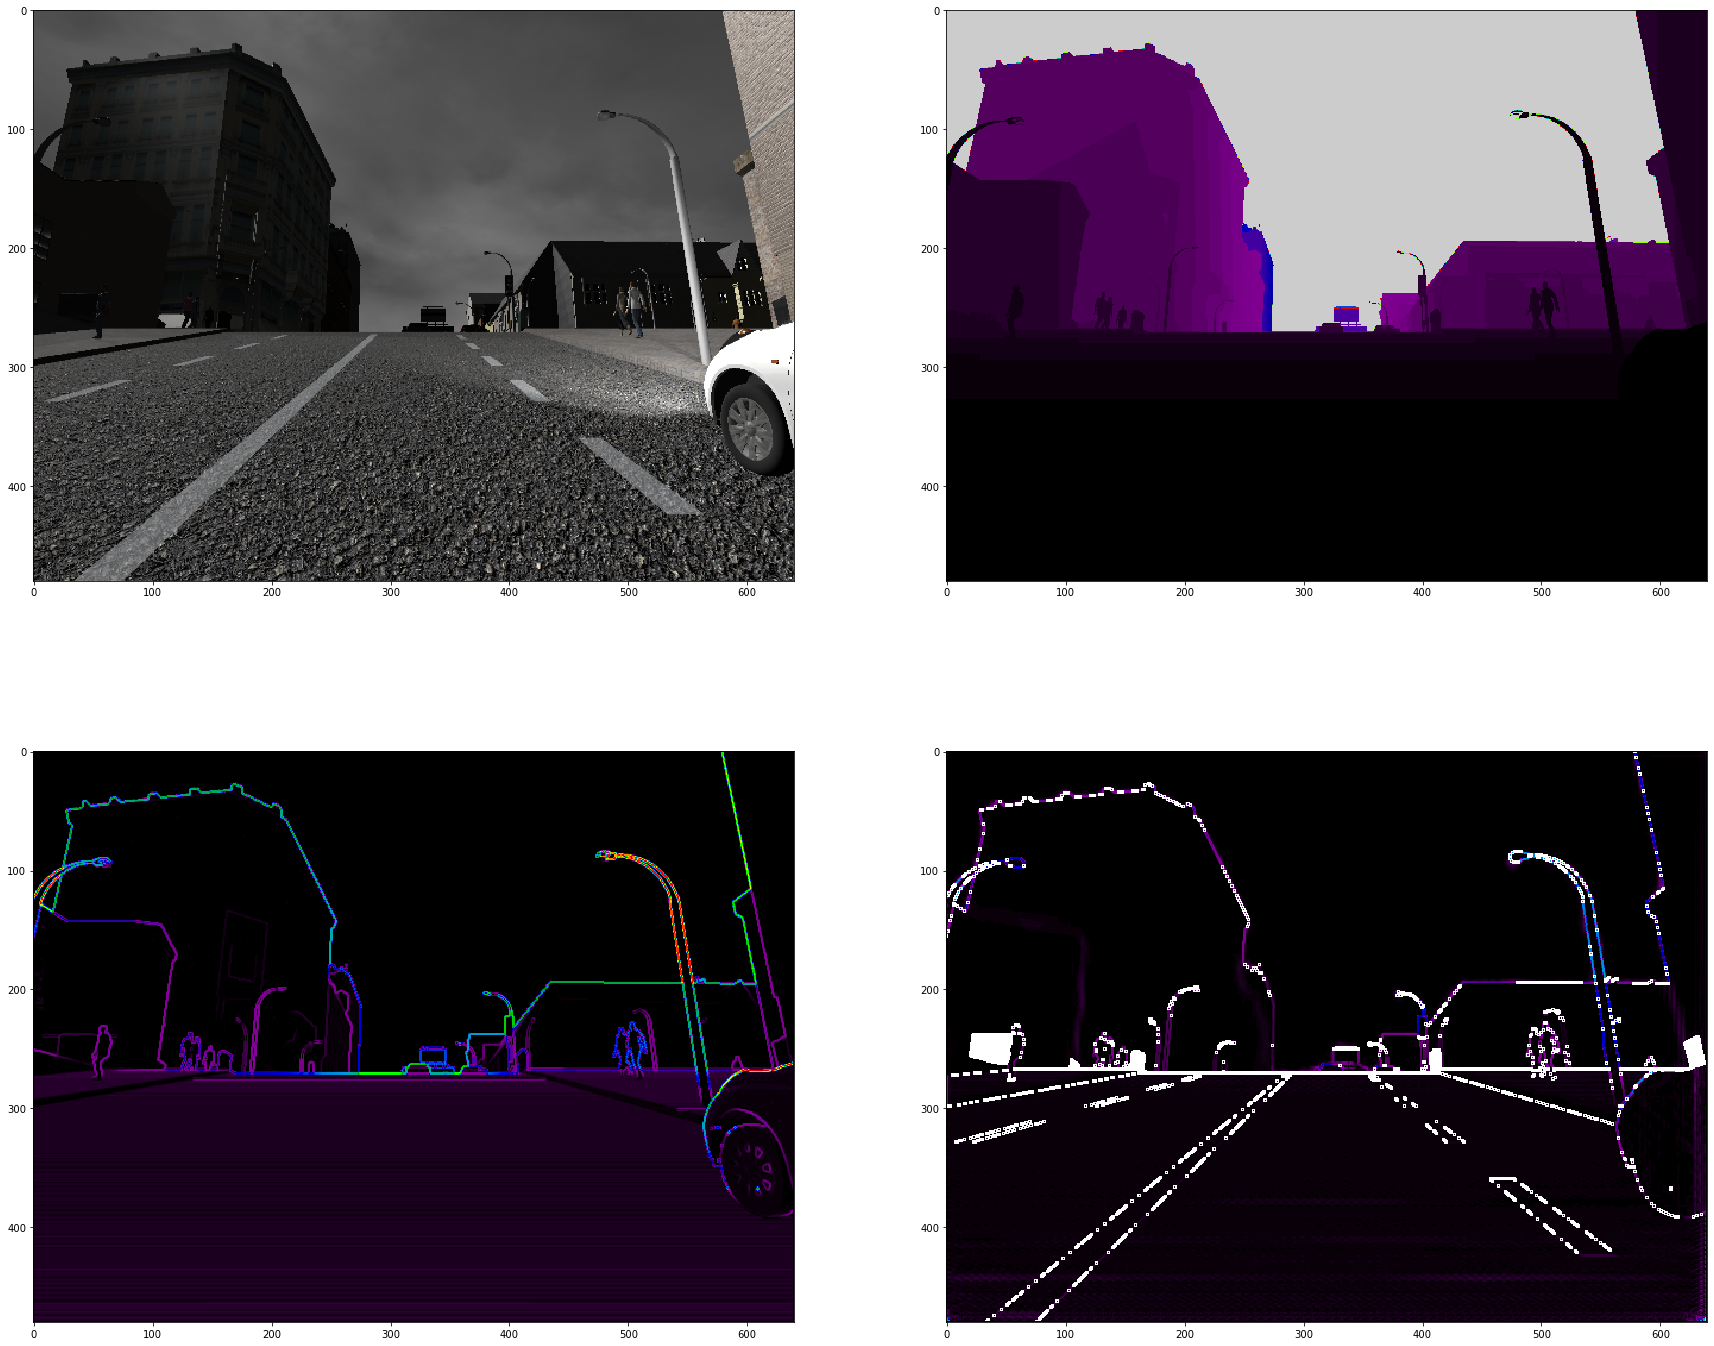

In [22]:
plt.figure(figsize=(30,25))
plt.subplot(2,2,1)
plt.imshow(feature_list[0][0])

plt.subplot(2,2,2)
plt.imshow(label_list[0][0,:,:,0])
plt.set_cmap('nipy_spectral')#prism

plt.subplot(2,2,3)
edge1 = skimage.filters.sobel(logol(label_list[0][0,:,:,0], 1.1, 4))
plt.imshow(edge1)
plt.set_cmap('nipy_spectral')#hot

plt.subplot(2,2,4)
edge2 = skimage.filters.sobel(logol(predict[0][0,:,:,0], 1.1, 4))
plt.imshow(edge2)
plt.set_cmap('nipy_spectral')# hot


### Semantic MAPE Evaluation

In [31]:
dsg_validation.index = dsg_validation.start_index
preview = iter(dsg_validation)
m =metrics.MAPE()
mape=0

for i in range(dsg_validation.size):
    feature_list, label_list=next(preview)
    predict = model.predict(feature_list)
    mape += m(feature_list[1][0,:,:,16]*label_list[0][:,:,:,0],
           feature_list[1][0,:,:,16]*predict[0][:,:,:,0])
    print(i/dsg_validation.size, '%')


0.0 %
0.0008992805755395684 %
0.0017985611510791368 %
0.002697841726618705 %
0.0035971223021582736 %
0.0044964028776978415 %
0.00539568345323741 %
0.006294964028776978 %
0.007194244604316547 %
0.008093525179856115 %
0.008992805755395683 %
0.009892086330935251 %
0.01079136690647482 %
0.011690647482014389 %
0.012589928057553957 %
0.013489208633093525 %
0.014388489208633094 %
0.015287769784172662 %
0.01618705035971223 %
0.0170863309352518 %
0.017985611510791366 %
0.018884892086330936 %
0.019784172661870502 %


KeyboardInterrupt: 